In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import numpy as np
from pmdarima import auto_arima
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

In [4]:
import pandas as pd

# Step 1: Load data
df = pd.read_excel("data/sales.xlsx")

# Step 2: Combine date and time into a single datetime column
df['timestamp'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str))

# Step 3: Calculate total revenue per transaction
df['revenue'] = df['transaction_qty'] * df['unit_price']

# Step 4: Set timestamp as index
df.set_index('timestamp', inplace=True)

# Optional: Drop original date and time columns if no longer needed
df.drop(columns=['transaction_date', 'transaction_time'], inplace=True)

# Step 5: Resample and aggregate - Daily level (you can also change to 'W' or 'M' for weekly/monthly)
# We'll sum revenue and quantity per day
df_daily = df.resample('D').agg({
    'revenue': 'sum',
    'transaction_qty': 'sum'
})

In [5]:
df_daily

,revenue,transaction_qty
timestamp,,
2023-01-01,2508.20,802
2023-01-02,2403.35,790
2023-01-03,2565.00,823
2023-01-04,2220.10,726
2023-01-05,2418.85,778
...,...,...
2023-06-26,5875.90,1837
2023-06-27,5975.65,1962
2023-06-28,4728.90,1531


In [ ]:
# Step 1: Load the data
df = pd.read_excel("data/sales.xlsx")

# Step 2: Create a timestamp column
df['timestamp'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str))

# Step 3: Compute revenue
df['revenue'] = df['transaction_qty'] * df['unit_price']

# Step 4: Drop unused columns if desired
df.drop(columns=['transaction_date', 'transaction_time'], inplace=True)

# Step 5: Set timestamp as index for resampling
df.set_index('timestamp', inplace=True)

# Step 6: Resample with segmentation - Daily total revenue and quantity per store and product
df_segmented = df.groupby(['store_location', 'product_category']) \
    .resample('D') \
    .agg({
        'revenue': 'sum',
        'transaction_qty': 'sum'
    }).reset_index()

df_segmented.head()


,store_location,product_category,timestamp,revenue,transaction_qty
0,Astoria,Bakery,2023-01-01,61.00,17
1,Astoria,Bakery,2023-01-02,127.25,36
2,Astoria,Bakery,2023-01-03,77.00,22
3,Astoria,Bakery,2023-01-04,81.50,23
4,Astoria,Bakery,2023-01-05,105.25,30


#### Feature Engineering

In [7]:
df_segmented['year'] = df_segmented['timestamp'].dt.year
df_segmented['month'] = df_segmented['timestamp'].dt.month
df_segmented['day'] = df_segmented['timestamp'].dt.day
df_segmented['dayofweek'] = df_segmented['timestamp'].dt.dayofweek
df_segmented['is_weekend'] = df_segmented['dayofweek'].isin([5, 6]).astype(int)
df_segmented['weekofyear'] = df_segmented['timestamp'].dt.isocalendar().week

df_segmented['revenue_lag1'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(1)
df_segmented['revenue_lag7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(7)
df_segmented['revenue_lag30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(30)

df_segmented['rolling_mean_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df_segmented['rolling_std_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).std())
df_segmented['rolling_mean_30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=30).mean())

df_segmented['cumulative_revenue'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].cumsum()

df_segmented = pd.get_dummies(df_segmented, columns=['store_location', 'product_category'], drop_first=True)



In [8]:
df_segmented.dropna(inplace=True)

### ARIMA/SARIMA Model

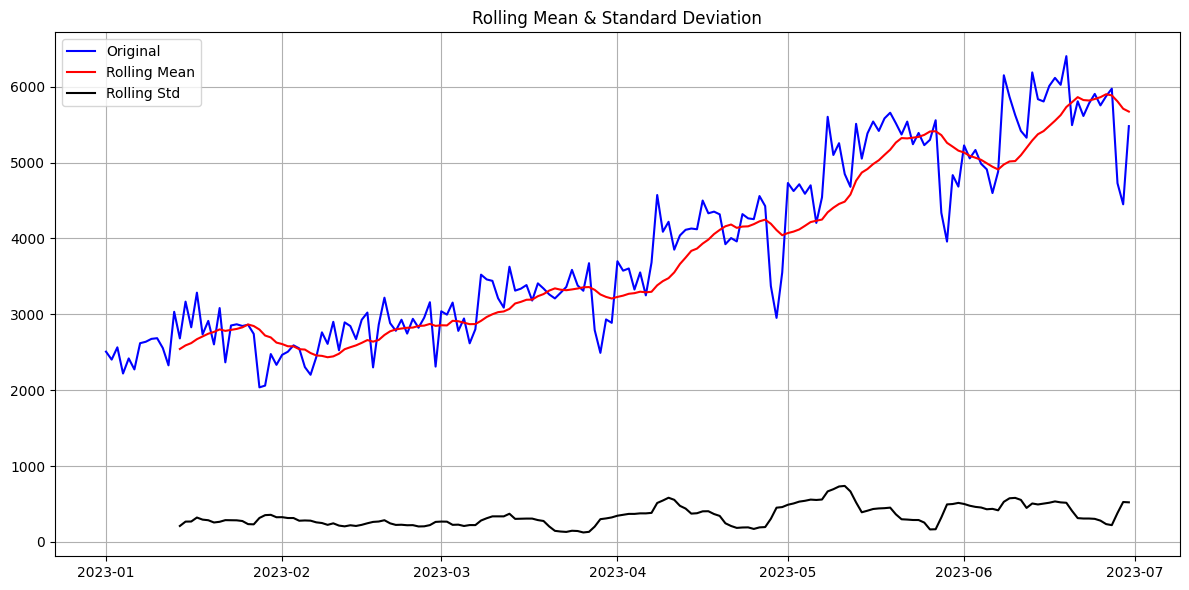

ADF Statistic: -0.7085692033124135
p-value: 0.8445174174763055
Critical Value (1%): -3.470126426071447
Critical Value (5%): -2.8790075987120027
Critical Value (10%): -2.5760826967621644


In [ ]:
df = pd.read_excel("data/sales.xlsx", parse_dates=["transaction_date"])
df['timestamp'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str))
df['revenue'] = df['transaction_qty'] * df['unit_price']
df = df.groupby("timestamp")["revenue"].sum().resample("D").sum()

rolmean = df.rolling(window=14).mean()
rolstd = df.rolling(window=14).std()

plt.figure(figsize=(12, 6))
plt.plot(df, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title("Rolling Mean & Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform ADF Test
adf_result = adfuller(df.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

#### Interpret output:

1. ADF Statistic should be less than critical values

2. p-value < 0.05: We reject H₀ → data is stationary

As from our output we can see that is not the case so we will apply differencing technique to make the data stationary

#### Differencing

To make the series stationary, we’ll apply first-order differencing.
This helps remove trend or seasonality by subtracting the current value from the previous value
​


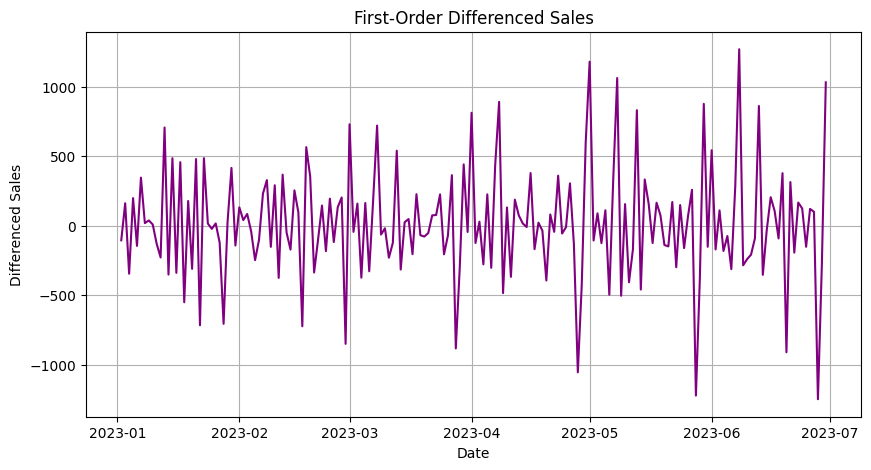

ADF Test After First-Order Differencing:
ADF Statistic: -4.024365142909468
p-value: 0.0012881667861322397
Critical Value (1%): -3.470616369591229
Critical Value (5%): -2.8792214018977655
Critical Value (10%): -2.57619681359045


In [ ]:
# Apply first-order differencing
sales_diff = df_daily['revenue'].diff().dropna()

plt.figure(figsize=(10, 5))
plt.plot(sales_diff, color='purple')
plt.title('First-Order Differenced Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.grid(True)
plt.show()

# Recheck stationarity using ADF test
adf_result_diff = adfuller(sales_diff)
print("ADF Test After First-Order Differencing:")
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

In [ ]:
# Fit Auto ARIMA model
auto_model = auto_arima(
    df_daily['revenue'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1,  # We already differenced once
    seasonal=False, 
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2669.949, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2658.972, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2646.384, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2668.259, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2637.163, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2639.155, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2639.155, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2638.294, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2654.061, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2639.322, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.261 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  181
M

Evaluation Metrics:
MAE:  300.74
RMSE: 449.92
MAPE: 5.54%


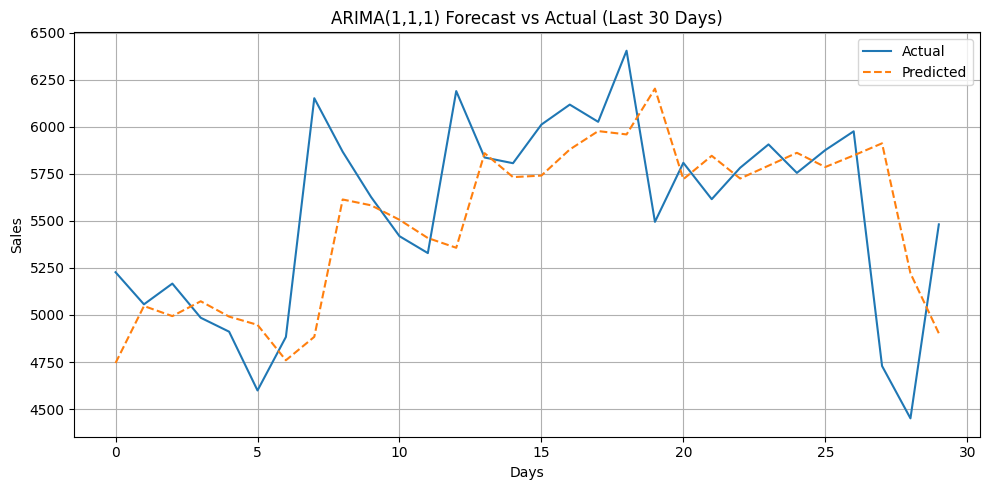

In [14]:
data = df_daily["revenue"]

# Define walk-forward validation function
def walk_forward_validation(data, order, test_size=30):
    predictions = []
    history = list(data[:-test_size])
    test = data[-test_size:]
    actuals = list(test)

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(actuals[t])  # expand training window

    return actuals, predictions

# Perform validation using the best ARIMA model (1,1,1)
actual, predicted = walk_forward_validation(data, order=(1,1,1), test_size=30)

# Convert to numpy arrays for metric calculation
actual = np.array(actual)
predicted = np.array(predicted)

# Evaluate
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted)

print(f"Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted", linestyle="--")
plt.title("ARIMA(1,1,1) Forecast vs Actual (Last 30 Days)")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

_____________________________________________________________________________________________________________________